# Resnet50

In [16]:
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
import tensorflow as tf
import numpy as np
import pathlib
import PIL
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH  = 'images_resnet50'
IMAGE_SIZE = (180, 180)
NUM_CLASSES = 2
BATCH_SIZE = 10
FREEZE_LAYERS = 2
NUM_EPOCHS = 10
WEIGHTS_FINAL = './models/model-resnet50-final.h5'

In [3]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 640 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [4]:
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Class #0 = ok
Class #1 = thumb


In [5]:
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

In [6]:
x = Dropout(0.5)(x)

In [7]:
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

In [8]:
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

In [9]:
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
net_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 90, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

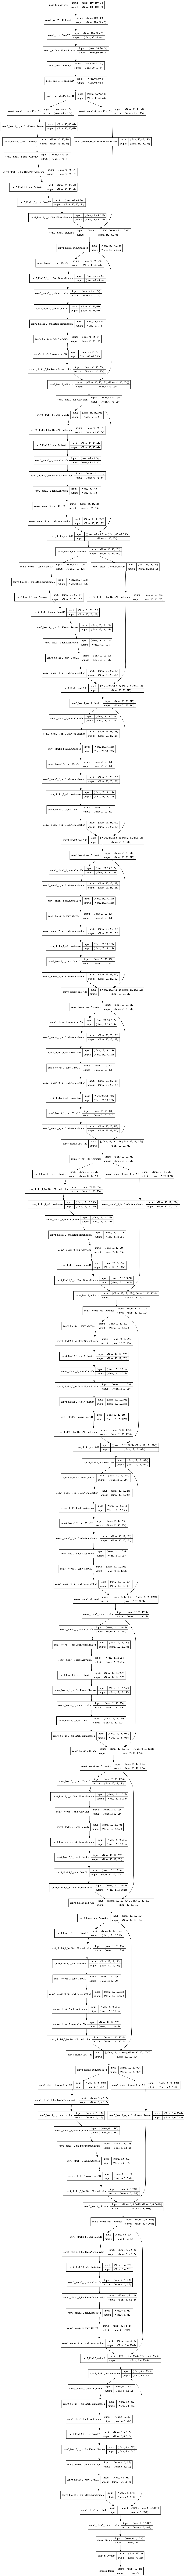

In [11]:
keras.utils.plot_model(net_final, "resnet_model_v1.png", show_shapes=True)

In [13]:
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
64/64 [==============================] - 301s 5s/step - loss: 1.1270 - accuracy: 0.6631 - val_loss: 0.1303 - val_accuracy: 0.9187
Epoch 2/10
64/64 [==============================] - 287s 4s/step - loss: 0.3855 - accuracy: 0.8485 - val_loss: 0.0396 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - 262s 4s/step - loss: 0.1751 - accuracy: 0.9392 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 251s 4s/step - loss: 0.1022 - accuracy: 0.9697 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 274s 4s/step - loss: 0.0534 - accuracy: 0.9826 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 302s 5s/step - loss: 0.0579 - accuracy: 0.9841 - val_loss: 2.4059e-04 - val_accuracy: 1.0000
Epoch 7/10
64/64 [==============================] - 271s 4s/step - loss: 0.0590 - accuracy: 0.9791 - val_loss: 2.4042e-04 - val_accuracy: 1.0000
Epoch

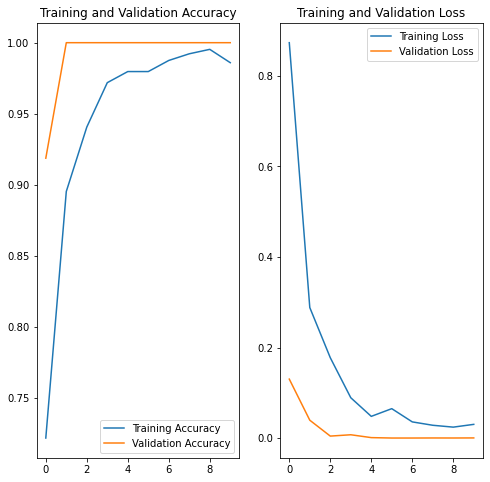

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
net_final.save(WEIGHTS_FINAL)

In [19]:
img_height = 180
img_width = 180
test_file_path = "./test_images"
test_file_path = pathlib.Path(test_file_path)
thumb_test_file_path = "./test_images/thumb/frame_01_05_0005.png"


img = keras.preprocessing.image.load_img(
    thumb_test_file_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = net_final.predict(img_array)
score = tf.nn.softmax(predictions[0])

percent_confidence = "{:.2f}".format(100 * np.max(score))

print("This image most likely belongs thumb to with a "+str(percent_confidence)+" percent confidence.")

This image most likely belongs thumb to with a 72.92 percent confidence.


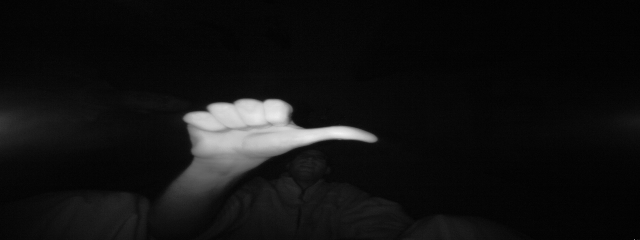

In [20]:
thumb_test = list(test_file_path.glob('thumb/frame_01_05_0005.png'))
PIL.Image.open(str(thumb_test[0]))

In [21]:
img_height = 180
img_width = 180
test_file_path = "./test_images"
test_file_path = pathlib.Path(test_file_path)
thumb_test_file_path = "./test_images/ok/frame_06_07_0009.png"


img = keras.preprocessing.image.load_img(
    thumb_test_file_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = net_final.predict(img_array)
score = tf.nn.softmax(predictions[0])

percent_confidence = "{:.2f}".format(100 * np.max(score))

print("This image most likely belongs ok to with a "+str(percent_confidence)+" percent confidence.")

This image most likely belongs ok to with a 73.11 percent confidence.


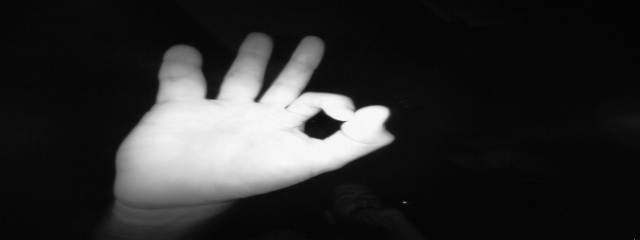

In [22]:
ok_test = list(test_file_path.glob('ok/frame_06_07_0009.png'))
PIL.Image.open(str(ok_test[0]))

In [28]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image
import sys
import numpy as np

files = sys.argv[1:]

#net = load_model('./models/model-resnet50-final.h5')

cls_list = ['ok', 'thumb']

#f = "./test_images/thumb/frame_01_05_0005.png"
f = "./test_images/ok/frame_06_07_0009.png"

img = image.load_img(f, target_size=(180, 180))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
pred = net_final.predict(x)[0]
top_inds = pred.argsort()[::-1][:5]
print(f)
for i in top_inds:
    print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

./test_images/ok/frame_06_07_0009.png
    1.000  ok
    0.000  thumb
